# Configuration

In [20]:
n_phi_sectors        = 9
polynomial_degree_dr = 4
polynomial_degree_z  = 4

n_photons = 1e7
#n_photons = 3e6
#n_photons = 1e6
#n_photons = 3e5
#n_photons = 1e5

z_min =   0
z_max = 550
r_max = 217.5
r_max = 300
r_max = 195

# Setup

In [21]:
import os
import shutil
import collections

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core .core_functions as coref
import invisible_cities.core . fit_functions as  fitf
import invisible_cities.icaro. hst_functions as  hstf

In [22]:
profile = collections.namedtuple("profile", "x y u")

In [23]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 15

In [24]:
path_tables         = "/Volumes/SAMSUNG/NEWtables/S1/"
filename            = os.path.join(path_tables, "S1_old" , "S1table.dat")
filename            = os.path.join(path_tables, "S1_aug" , "S1table.dat")
#filename            = os.path.join(path_tables, "S1_fnal", "S1table.dat")
filename_pmt_map    = os.path.join(path_tables,        "pmt_mapping.dat")
filename_active_map = os.path.join(path_tables,     "active_mapping.dat")

In [25]:
def load_df(filename, df_active, df_pmt, zmin=0, zmax=530, rmax=205, nphi=9):
    two_pi   = 2 * np.pi

    df_table = pd.DataFrame.from_csv(filename, sep=" ", index_col=None)
    x_active = df_table. PointID.map(df_active.X)
    y_active = df_table. PointID.map(df_active.Y)
    z_active = df_table. PointID.map(df_active.Z)
    x_pmt    = df_table.SensorID.map(df_pmt   .X)
    y_pmt    = df_table.SensorID.map(df_pmt   .Y)
    phi      = df_table.SensorID.map(df_pmt   .Phi)
    s        = np.sin(phi)
    c        = np.cos(phi)
    dx       = x_active - x_pmt
    dy       = y_active - y_pmt
    r_active = np.sqrt(x_active**2 + y_active**2)

    df_table["Prob"      ] = df_table.Prob * 100
    df_table["Ring"      ] = df_table.SensorID.map(df_pmt.Corona)
    df_table["Uncert"    ] = np.clip(np.sqrt(df_table.Prob / n_photons), 5/n_photons, np.inf)
    df_table["dR"        ] = np.sqrt(dx**2 + dy**2)
    df_table["dPhi"      ] = (np.arctan2(dy, dx) - phi + two_pi) % two_pi
    df_table["dPhi_index"] = dphi_to_index(df_table.dPhi, nphi)
    df_table["X"         ] = x_active 
    df_table["Y"         ] = y_active 
    df_table["Z"         ] = z_active 
    df_table["R"         ] = r_active 

    new_columns = ["PointID", "SensorID", "Ring", "dR", "dPhi", "X", "Y", "Z", "dPhi_index", "R", "Prob", "Uncert"]
    df_table    = df_table[df_table.R <= rmax]
    df_table    = df_table[df_table.Z >= zmin]
    df_table    = df_table[df_table.Z <= zmax]
    df_table    = df_table.reindex(columns = new_columns)
    df_table.sort_values("SensorID")
    return df_table

def dphi_to_index(dphi, n_sectors):
    dphi_sector_width = np.pi / n_sectors
    dphi = np.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return (dphi // dphi_sector_width).astype(int)

def generate_seed(degree, ydata):
    return (1,) * degree + (np.mean(ydata),)
    

In [26]:
pmt      = pd.DataFrame.from_csv(filename_pmt_map   , sep=" ", index_col=0)
active   = pd.DataFrame.from_csv(filename_active_map, sep=" ", index_col=0)
df_table = load_df(filename, active, pmt, zmin=z_min, zmax=z_max, rmax=r_max, nphi=n_phi_sectors)

In [27]:
xy_binning = (np.arange(np.min(active.X) - 10, np.max(active.X) + 20 + 1, 10),
              np.arange(np.min(active.Y) - 10, np.max(active.Y) + 20 + 1, 10))
z_binning = np.arange(np.min(active.Z) - 1e-5, np.max(active.Z) + 1 + 1e-5, 10)

In [28]:
df_table.head()

,PointID,SensorID,Ring,dR,dPhi,X,Y,Z,dPhi_index,R,Prob,Uncert
12,1,0,0,331.397623,2.178059,-215,-205,0,6,297.069016,0.000023,0.000002
13,1,1,0,227.632669,6.138021,-215,-205,0,0,297.069016,0.000022,0.000001
14,1,2,0,343.233122,3.912743,-215,-205,0,6,297.069016,0.000021,0.000001
15,1,3,1,445.336951,2.637766,-215,-205,0,7,297.069016,0.000016,0.000001
16,1,4,1,359.785362,2.173119,-215,-205,0,6,297.069016,0.000016,0.000001


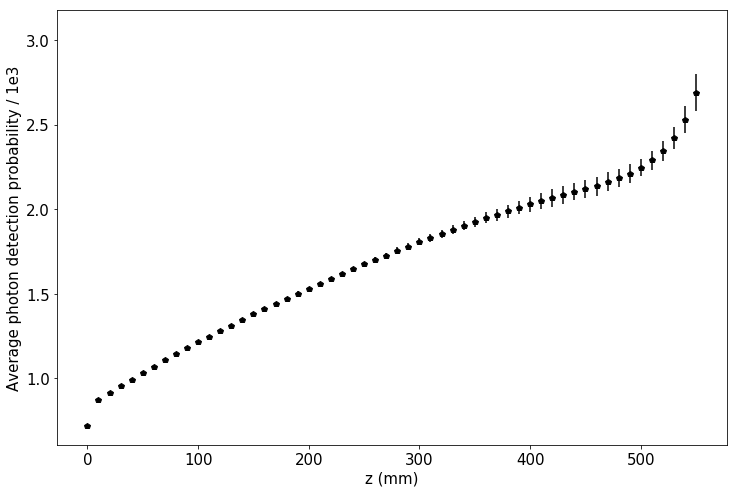

In [29]:
sel  = df_table.SensorID ==  0
sel &= df_table.dR       <  50
df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby("Z")
plt.errorbar(gb.Z.mean(), gb.Prob.mean(), gb.Prob.std(), fmt="pk")
plt.ylim(gb.Prob.min().min() * 0.9, gb.Prob.max().max() * 1.1)
plt.xlabel("z (mm)")
plt.ylabel("Average photon detection probability / 1e3")

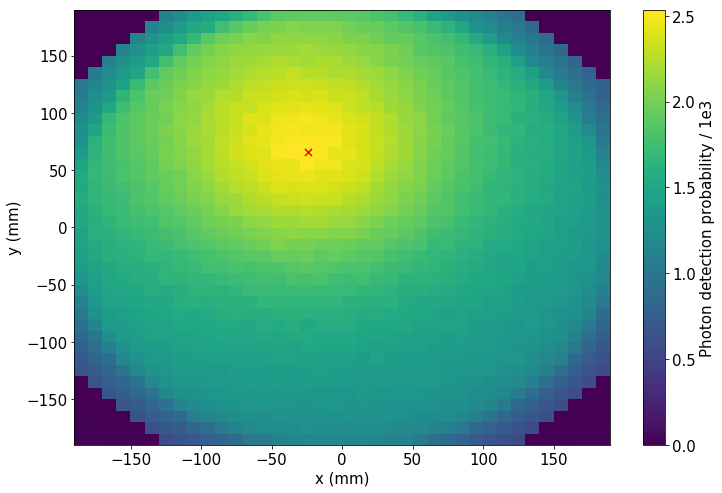

In [30]:
sel  = df_table.SensorID ==   0
sel &= df_table.Z        == 530

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 10),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 10))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3")

thispmt = pmt[pmt.index == 0]
plt.scatter(thispmt.X, thispmt.Y, s=50, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

In [31]:
pmt

,X,Y,R,Phi,Corona
SensorID,,,,,
0,-23.9414,65.7785,70.000012,1.919862,0
1,-44.9951,-53.6231,69.999971,-2.268928,0
2,68.9365,-12.1554,69.999963,-0.174533,0
3,-0.0000,185.0000,185.000000,1.570796,1
4,-118.9160,141.7180,185.000018,2.268930,1
5,-182.1890,32.1249,184.999570,2.967059,1
6,-160.2150,-92.5000,185.000260,-2.617995,1
7,-63.2737,-173.8430,184.999864,-1.919862,1
8,63.2737,-173.8430,184.999864,-1.221730,1


In [32]:
active.head()

,X,Y,Z
PointID,,,
0,-215,-215,0
1,-215,-205,0
2,-215,-195,0
3,-215,-185,0
4,-215,-175,0


# Control plots

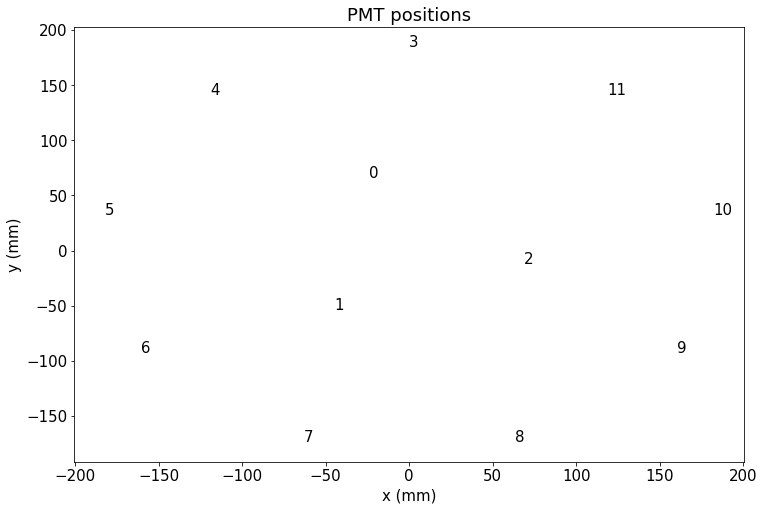

In [33]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(pmt_no)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT positions");

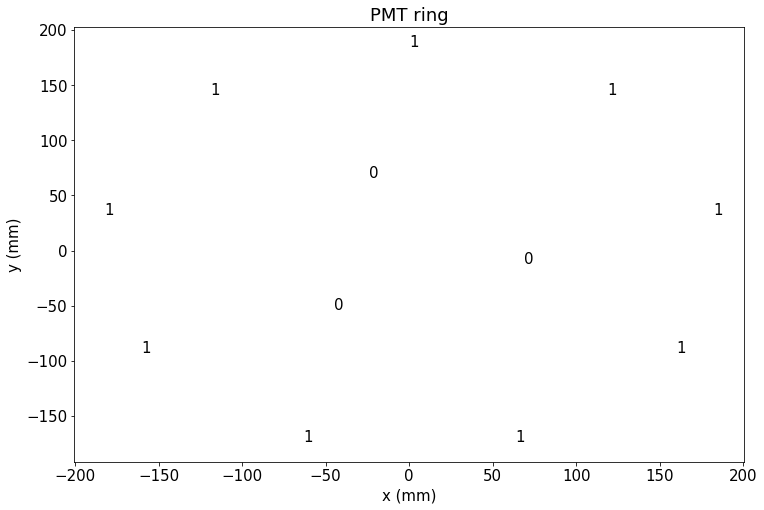

In [34]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(row.Corona)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT ring");

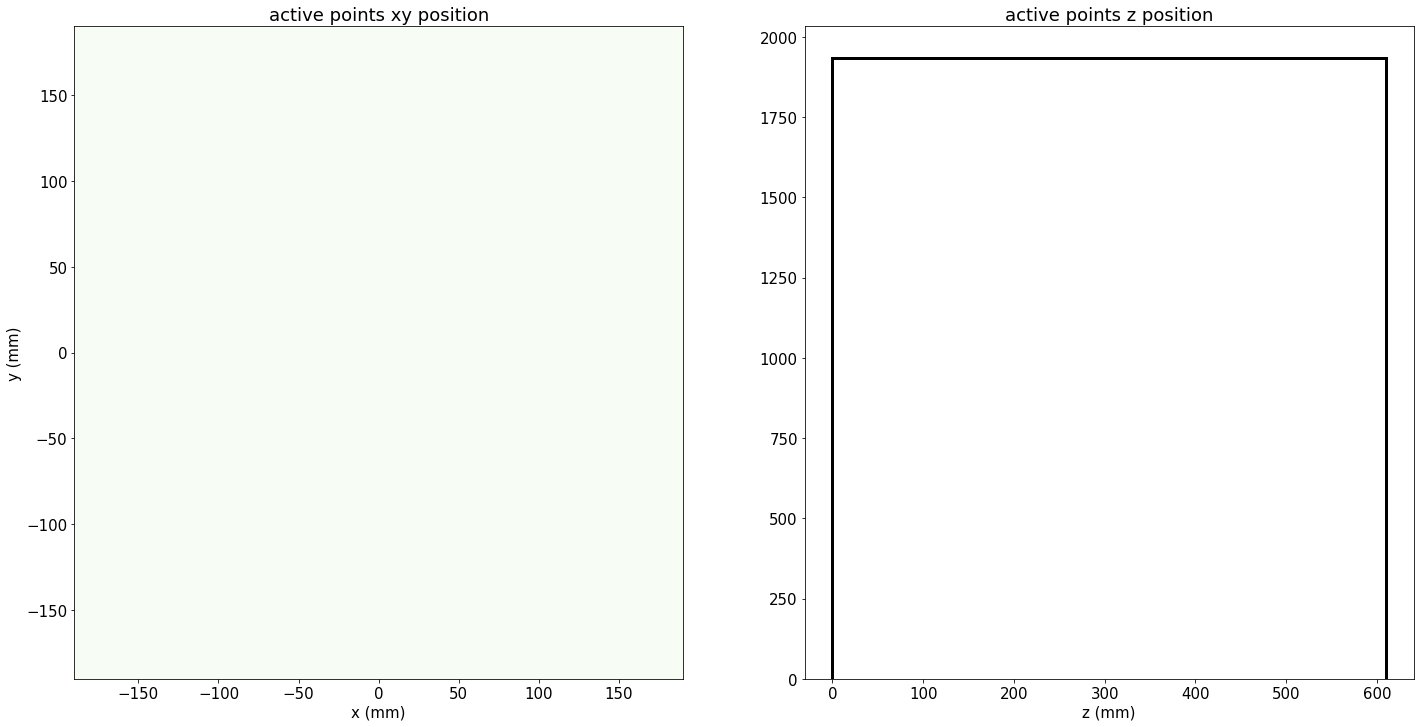

In [35]:
plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.hist2d(active.X, active.Y, xy_binning, cmap="Greens")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("active points xy position")

plt.subplot(1, 2, 2)
plt.hist(active.Z, z_binning, histtype="step", color="k", lw=3)
plt.xlabel("z (mm)")
plt.title ("active points z position");

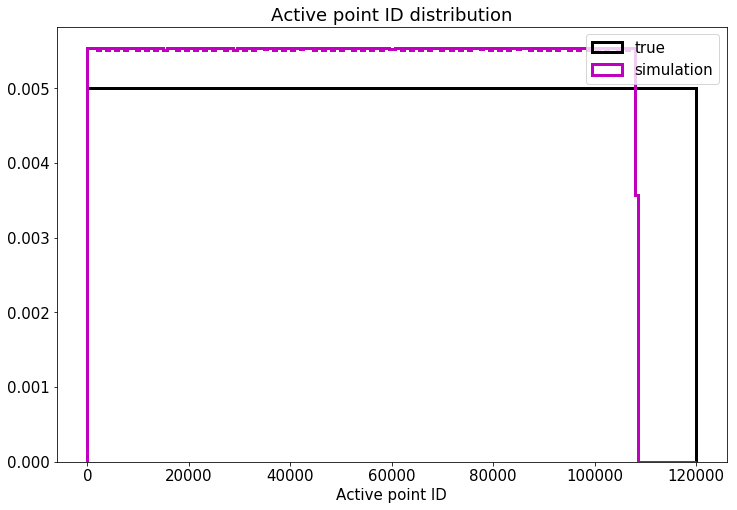

In [36]:
bins = np.linspace(active.index.min(), active.index.max(), 201)

weights = np.ones(len(active)) / len(active)
plt.hist(active.index, bins=bins, weights=weights, color="k", histtype="step", lw=3, label="true")

weights = np.ones(len(df_table)) / len(df_table)
plt.hist(df_table.PointID, bins=bins, weights=weights, color="m", histtype="step", lw=3, label="simulation")

plt.legend()
plt.xlabel("Active point ID")
plt.ylabel("")
plt.title ("Active point ID distribution");

IndexError: index 5 is out of bounds for axis 0 with size 0

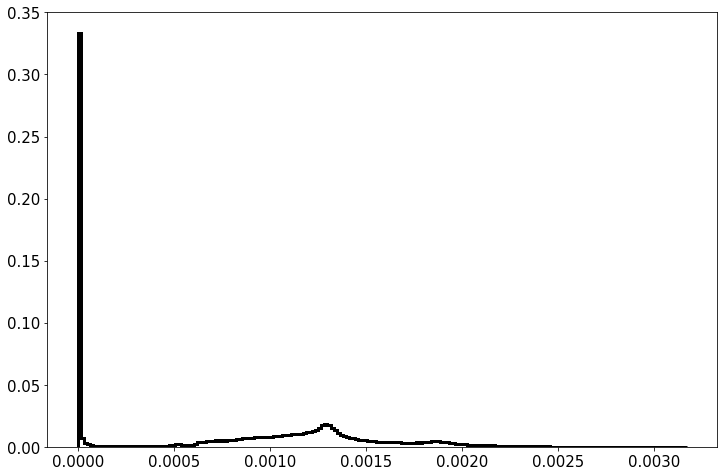

In [37]:
bins    = np.linspace(0, max(df_table.Prob), 201)
weights = np.ones(len(df_table)) / len(df_table)

y, x, _ = plt.hist(df_table.Prob, bins = bins, weights = weights, color="k", histtype="step", lw=3)

cut = x[:-1][y == 0][5]
plt.plot([cut, cut], plt.ylim(), "r-", lw=3)
plt.arrow(cut, np.mean(plt.ylim()), cut, 0,
          color="r", head_length=0.1*cut, head_width=0.1*np.mean(plt.ylim()))

plt.xlabel("Photon detection probability")
plt.ylabel("Fraction of events")
plt.yscale("log")

# PMT parametrization

In [19]:
print(f"Selecting data with P > {cut*1e5:.3f} · 10^{-5}")
df_table = df_table[df_table.Prob > cut]

Selecting data with P > 7.921 · 10^-5


In [ ]:
dr_binning   = np.linspace(0, df_table.dR.max() * 1.001, 101)
dphi_binning = np.linspace(0, 2 * np.pi * 1.001, 101)
p_binning    = np.linspace(0, np.max(df_table.Prob) * 1.001, 101)

In [ ]:
plt.figure(figsize=(24, 12))

for ring_no, ring in df_table[df_table.Z == z_max].groupby("Ring"):
    plt.subplot(1, 2, ring_no + 1)
    x, y, z, u = fitf.profileXY(ring.dR, ring.dPhi, ring.Prob, dr_binning.size - 1, dphi_binning.size - 1,
                                xrange = (  dr_binning[0],   dr_binning[-1]),
                                yrange = (dphi_binning[0], dphi_binning[-1]))
    *_, cb = hstf.display_matrix(x, y, z, new_figure=False,
                                 cmap = "jet",
                                 cmin = 1e-8,
                                )
    plt.xlabel("dr (mm)")
    plt.ylabel("d$\phi$ (rad)")
    cb.set_label("Photon detection probability / 1e5", rotation=-90, labelpad=20)

In [ ]:
defaultdict         = collections.defaultdict
dr_parametrizations = defaultdict(lambda: defaultdict(defaultdict))
dr_coefficients     = defaultdict(lambda: defaultdict(defaultdict))
dr_uncertainties    = defaultdict(lambda: defaultdict(defaultdict))
dr_profiles         = defaultdict(lambda: defaultdict(defaultdict))
dr_pulls            = defaultdict(lambda: defaultdict(defaultdict))
dr_oks              = defaultdict(lambda: defaultdict(defaultdict))
sub_dfs             = []
empty_fun           = lambda x: np.zeros_like(x)
empty_fun.fn        = empty_fun

for (ring, dphi, z), data in df_table.groupby(["Ring", "dPhi_index", "Z"]):
    dr = data.dR
    p  = data.Prob
    u  = data.Uncert
    try:
        if len(data) <= 4: raise TypeError
        f  = fitf.fit(fitf.polynom, dr, p,
                      generate_seed(polynomial_degree_dr, p),
                      sigma=u, maxfev=int(1e5))
        dr_oks = True

        prediction = f.fn(dr)
        pull       = (prediction - p) / (prediction / n_photons)**0.5

        dr_parametrizations[ring][dphi][z] = f
        dr_coefficients    [ring][dphi][z] = f.values
        dr_uncertainties   [ring][dphi][z] = f.errors
        dr_profiles        [ring][dphi][z] = profile(dr, p, u)
        dr_pulls           [ring][dphi][z] = pull

        ring = np.full(polynomial_degree_dr + 1, ring)
        dphi = np.full(polynomial_degree_dr + 1, dphi)
        z    = np.full(polynomial_degree_dr + 1,    z)
        idx  = np.arange(polynomial_degree_dr + 1)

        sub_df = pd.DataFrame(dict(ring=ring, dphi_index=dphi, z=z,
                                   drc_index=idx,
                                   coeff=f.values, uncert=f.errors))
        sub_dfs.append(sub_df)
    except TypeError as e:
        dr_parametrizations[ring][dphi][z] = empty_fun
        dr_coefficients    [ring][dphi][z] = np.zeros(polynomial_degree_dr)
        dr_uncertainties   [ring][dphi][z] = np.zeros(polynomial_degree_dr)
        dr_profiles        [ring][dphi][z] = profile(dr, p, u)
        dr_pulls           [ring][dphi][z] = np.zeros_like(p)
        df_oks                             = False

dr_df = pd.concat(sub_dfs, ignore_index=True)

In [ ]:
defaultdict        = collections.defaultdict
z_parametrizations = defaultdict(lambda: defaultdict(defaultdict))
z_coefficients     = defaultdict(lambda: defaultdict(defaultdict))
z_uncertainties    = defaultdict(lambda: defaultdict(defaultdict))
z_profiles         = defaultdict(lambda: defaultdict(defaultdict))
sub_dfs           = []

for (ring, dphi, ridx), data in dr_df.groupby(["ring", "dphi_index", "drc_index"]):
    z  = data.z     
    c  = data.coeff
    u  = data.uncert
    f  = fitf.fit(fitf.polynom, z, c, 
                  generate_seed(polynomial_degree_z, c),
                  sigma=u, maxfev=int(1e6))

    z_parametrizations[ring][dphi][ridx] = f
    z_coefficients    [ring][dphi][ridx] = f.values
    z_uncertainties   [ring][dphi][ridx] = f.errors
    z_profiles        [ring][dphi][ridx] = profile(z, c, u)

    ring = np.full(polynomial_degree_z + 1, ring)
    dphi = np.full(polynomial_degree_z + 1, dphi)
    ridx = np.full(polynomial_degree_z + 1, ridx)
    zidx = np.arange(polynomial_degree_z + 1)

    sub_df = pd.DataFrame(dict(ring=ring, dphi_index=dphi,
                               drc_index=ridx, zc_index=zidx,
                               coeff=f.values, uncert=f.errors))
    sub_dfs.append(sub_df)

z_df = pd.concat(sub_dfs, ignore_index=True)

In [ ]:
rg   = []
dp   = []
z    = []
r    = []
pull = []
for (ring, dphi), data in df_table.groupby(["Ring", "dPhi_index"]):
    coeffs = z_df[(z_df.ring == ring) & (z_df.dphi_index == dphi)]
    param = sum(row.coeff * data.Z**row.zc_index * data.dR**row.drc_index
                for _, row in coeffs.iterrows()) * n_photons
    table = data.Prob * n_photons
    where = (table > 0) & (param > 0)
    pull_values= ((param - table) / (param)**0.5)[where]
    pull.extend(pull_values)
    rg  .extend([ring] * np.count_nonzero(where))
    dp  .extend([dphi] * np.count_nonzero(where))
    z   .extend(data.Z[where])
    r   .extend(data.R[where])

pull = np.array(pull)
ok   = np.isfinite(pull)
pull = pull[ok]
rg   = np.array(rg)[ok]
dp   = np.array(dp)[ok]
z    = np.array( z)[ok]
r    = np.array( r)[ok]

In [ ]:
pull_binning = np.linspace(-10, 10, 100)
y, x = np.histogram(pull[np.isfinite(pull)], pull_binning)
x    = x[:-1] + np.diff(x) / 2
f    = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))

plt.hist  (pull, pull_binning, histtype="step", color="k", lw=3)
plt.plot  (x, f.fn(x), "r-", lw=3)
plt.text  (0.7, 0.7, f"µ = {f.values[1]:.3f}\nσ = {f.values[2]:.3f}", transform=plt.gca().transAxes, fontsize=25)
plt.xlabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")
plt.ylabel("Number of occurrences")

In [ ]:
r_binning = np.linspace(0, 215, 101)
plt.hist2d(r[rg==1], pull[rg==1], (r_binning, pull_binning))
plt.xlabel( "r (mm)")
plt.ylabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")

In [ ]:
plt.hist2d(z, pull, (z_binning, pull_binning))
plt.xlabel( "z (mm)")
plt.ylabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")

fitf.profileX(z, pull, z_binning.size -1, (z_binning[0], z_binning[-1]), std=True)

In [ ]:
ring     =   0
z        = 250
nphi     =   2
dr, p, u = dr_profiles        [ring][nphi][z]
f        = dr_parametrizations[ring][nphi][z]
dr_      = np.linspace(0, 230, 100)

plt.errorbar(dr , p * 1e5, u * 1e5, fmt="kp")
plt.plot    (dr_, f.fn(dr_) * 1e5, "r-")

plt.xlabel("dr (mm)")
plt.ylabel("Photon detection probability / 1e5")
plt.tight_layout()

In [ ]:
ring =   1
z    =  280 - 200
dr_  = np.linspace(0, 230, 100)

plt.figure(figsize=(24, 24))
for nphi in range(9):
    dr, p, u = dr_profiles        [ring][nphi][z]
    f        = dr_parametrizations[ring][nphi][z]
    
    plt.subplot(3, 3, nphi + 1)
    plt.errorbar(dr , p * 1e5, u * 1e5, fmt="kp")
#    plt.scatter(dr , p * 1e5, c="k")
    plt.plot    (dr_, f.fn(dr_) * 1e5, "r-")
    plt.xlim(0, dr.max() * 1.1)
    plt.ylim(0, p.max() * 1.1 * 1e5)
    plt.xlabel("dr (mm)")
    plt.ylabel("Photon detection probability / 1e5")
plt.tight_layout()

In [ ]:
ring = 0
dphi = 0
z_   = np.linspace(0, z_max, 100)

plt.figure(figsize=(24, 24))
for r in range(polynomial_degree_dr + 1):
    z, c, u = z_profiles        [ring][dphi][r]
    f       = z_parametrizations[ring][dphi][r]
    
    plt.subplot (polynomial_degree_dr + 1, 1, r + 1)
    plt.errorbar(z , c, u, fmt="pk")
    plt.plot    (z_, f.fn(z_), "r-")

    plt.ylim  ((c-u).min(), (c+u).max())
    plt.xlabel("z (mm)")
    plt.ylabel("Coefficient")
plt.tight_layout()

In [ ]:
ring =   0
z    = 480
dr_  = np.linspace(0, 150, 100)

plt.figure(figsize=(24, 24))
for nphi in range(9):
    dr, p, u = dr_profiles        [ring][nphi][z]
    f        = dr_parametrizations[ring][nphi][z]
    
    plt.subplot(3, 3, nphi + 1)
#    plt.errorbar(dr , p * 1e5, u * 1e5, fmt="kp")
    plt.scatter(dr , p, c="k")
    plt.plot    (dr_, f.fn(dr_), "r-")
    plt.ylim(0, p.max() * 1.1)
    plt.xlabel("dr (mm)")
    plt.ylabel("Photon detection probability / 1e5")
plt.tight_layout()